<a href="https://colab.research.google.com/github/flaymax/article/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Work with Transformers

##### Fine tune BERT on classification task

In [1]:
!pip install transformers
# !pip install sentencepiece==0.1.94
#!pip install 'lightning-flash[text]' --upgrade
import random
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, AutoModelForSeq2SeqLM

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
df = pd.read_excel('Lemmatized_закупки_2020_исходная_выгрузка_340к.xlsx', sheet_name='Наим_без_дубликатов')
columns_ = df.columns
for column in columns_:
    if column not in ['name', 'РИ']:
        df.drop(column, axis=1, inplace=True)
df.rename(columns = {'name' : 'data', 'РИ' : 'target'}, inplace=True)
df

,data,target
0,"Электроэнергия,произведенная электростанциями ...",0
1,"Электроэнергия, произведенная гидроэлектростан...",0
2,"4010419: Электроэнергия, произведенная электро...",0
3,"Электроэнергия, произведенная электростанциями...",0
4,"Электроэнергия, произведенная дизельными элект...",0
...,...,...
150959,Вибростенды,0
150960,Вибростенды,0
150961,Модернизация и дальнейшее развитие Единой терр...,0
150962,Модернизация и развитие комплекса специализиро...,0


In [3]:
# Use a GPU if you have one available (Runtime -> Change runtime type -> GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set seeds for reproducibility
random.seed(26)
np.random.seed(26)
torch.manual_seed(26)

#tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")
#model = AutoModelForSequenceClassification.from_pretrained("DeepPavlov/rubert-base-cased")
#model.to(device)

#learning_rate = 1e-5
#optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)

In [4]:
from sklearn.model_selection import train_test_split


In [5]:
labels=set(df['target'])
id2label = {i:label for i,label in enumerate(labels) if label != None}
label2id = {label:i for i,label in enumerate(labels) if label != None}

In [6]:
X = df['data']
y = df['target']

In [7]:
import re
import string

def preprocessing_text(txt):
    txt = txt.lower()
    txt = re.sub(r'\n',' ', txt)
    txt = re.sub('[%s]' % re.escape(string.punctuation), '', txt)
    txt = re.sub(r'\s+', ' ', txt, flags=re.I)
    txt = re.sub(r'\W', ' ', txt)
    return txt

In [8]:
X = X.apply(lambda x: preprocessing_text(x))


In [9]:
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.8, 
                                                      random_state=42)

In [10]:
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)


In [11]:
print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

(120771,)
(120771,)
(15096,)
(15096,)
(15097,)
(15097,)


(None, None)

In [12]:
y_test.value_counts()

0    10715
1     4382
Name: target, dtype: int64

In [13]:
y_valid.value_counts()

0    10810
1     4286
Name: target, dtype: int64

In [14]:
y_train.value_counts()

0    86200
1    34571
Name: target, dtype: int64

In [15]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification


In [16]:
MODEL_NAME = 'DeepPavlov/rubert-base-cased-sentence'


In [17]:
tokenizer = AutoTokenizer.from_pretrained('DeepPavlov/rubert-base-cased-sentence')


In [18]:
def make_dataset(X, y):
    labels = [label2id[label] for label in y]
    texts = [tokenizer(text,padding='max_length', max_length = 100, truncation=True) for text in X]
    
    result = []
    for idx,(text,label) in enumerate(zip(texts,labels)):
        result.append({"input_ids" : text['input_ids'], 'attention_mask' : text['attention_mask'], "label" : label})
    return result

In [19]:
train_dataset = make_dataset(X_train, y_train)


In [20]:
valid_dataset = make_dataset(X_valid, y_valid)


In [21]:
from transformers import TrainingArguments, Trainer


In [22]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, label2id=label2id,id2label=id2label,num_labels=len(labels))
model.to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-sentence and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [23]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'accuracy' : accuracy_score(predictions, labels),
            'precision' : precision_score(predictions, labels),
            'recall' : recall_score(predictions, labels),
            'f1 measure' : f1_score(predictions, labels)}

In [24]:
args = TrainingArguments(
    "test-glue",
    evaluation_strategy = "steps",
    learning_rate=1e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.05,
    #load_best_model_at_end=True,
    report_to=None,
    metric_for_best_model = 'accuracy'
    )
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
    )
trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 120771
  Num Epochs = 3
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 5664
  Number of trainable parameters = 177854978
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 measure
500,0.249100,0.186621,0.928723,0.853943,0.890511,0.871844
1000,0.178900,0.160072,0.939520,0.843910,0.936804,0.887934
1500,0.164900,0.149237,0.943561,0.837378,0.958600,0.893898
2000,0.151700,0.151679,0.945416,0.834811,0.968598,0.896742
2500,0.135000,0.152416,0.949391,0.853243,0.964399,0.905422
3000,0.130700,0.151200,0.949457,0.860476,0.957176,0.906254
3500,0.122300,0.135141,0.950517,0.867009,0.954534,0.908669
4000,0.118400,0.137323,0.952438,0.869809,0.958848,0.912161
4500,0.104200,0.141208,0.952173,0.880541,0.947289,0.912696
5000,0.104700,0.135517,0.953034,0.872375,0.958472,0.913399


***** Running Evaluation *****
  Num examples = 15096
  Batch size = 64
Saving model checkpoint to test-glue/checkpoint-500
Configuration saved in test-glue/checkpoint-500/config.json
Model weights saved in test-glue/checkpoint-500/pytorch_model.bin
tokenizer config file saved in test-glue/checkpoint-500/tokenizer_config.json
Special tokens file saved in test-glue/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 15096
  Batch size = 64
Saving model checkpoint to test-glue/checkpoint-1000
Configuration saved in test-glue/checkpoint-1000/config.json
Model weights saved in test-glue/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in test-glue/checkpoint-1000/tokenizer_config.json
Special tokens file saved in test-glue/checkpoint-1000/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 15096
  Batch size = 64
Saving model checkpoint to test-glue/checkpoint-1500
Configuration saved in test-glue/checkpoint-1500/config.js

TrainOutput(global_step=5664, training_loss=0.14106072611727957, metrics={'train_runtime': 6323.5973, 'train_samples_per_second': 57.295, 'train_steps_per_second': 0.896, 'total_flos': 1.8618858554814e+16, 'train_loss': 0.14106072611727957, 'epoch': 3.0})

In [25]:
class ClassifierLanguageModel():
	def __init__(self, model,tokenizer):
		self.model = model
		self.tokenizer = tokenizer

	def run(self, text):
		model_input = self.tokenizer.encode(text, return_tensors='pt').cuda()
		model_output = self.model.bert.config.id2label[self.model(model_input)['logits'].argmax().item()]
		return model_output

In [26]:
classyfier = ClassifierLanguageModel(model,tokenizer)


In [28]:
X1_test = X_test.apply(lambda x: ' '.join(x.split()))


In [33]:
X_test.to_numpy()

array(['оказание услуг по проведению экспертизы иили повторной экспертизы качества медицинской помощи по профилю  онкология  включая высокотехнологические методы лечения в условиях круглосуточного стационара для нужд тфомс мо в 2021 году ',
       'наборы реагентов для иммунохемилюминесцентного анализа на анализаторах immulite one immulite 1000 immulite 2000 для invitro диагностики показателей нарушения гормонального статуса и аутоиммунных процессов набор реагентов для определения общего тестостеронаtotal testosterone 200 тестов соединенное королевство siemens healthcare diagnostics products limited 10381190',
       'двухкомпонентный недренируемый калоприемник для втянутых стом в комплекте адгезивная пластина конвексная',
       ...,
       'ремонт протеза голени с заменой силиконового чехла и силиконового наконечника',
       'измеритель артериального давления и частоты пульса автоматический omronm2 basichem7121alruизмеритель артериального давления и частоты пульса автоматический omr

In [36]:
m_input = tokenizer.encode(X_test.to_numpy()[0], return_tensors='pt').cuda()
model.bert.config.id2label[model(m_input)['logits'].argmax().item()]

0

In [52]:
preds = []
err = []
reference = []
for test, label in zip(X_test.to_numpy(), y_test.to_numpy()):
  m_input = tokenizer.encode(test, return_tensors='pt').cuda()
  try:
    out = model.bert.config.id2label[model(m_input)['logits'].argmax().item()]
    reference.append(label)
    preds.append(out)
  except RuntimeError:
    continue

In [43]:
reference = []
for label in y_test[:3000]:
  reference.append(label)

Text(91.68, 0.5, 'true_value')

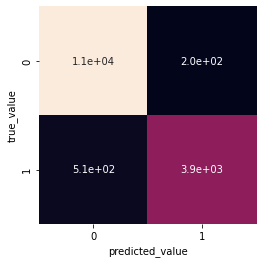

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

baseline_conf_mat = confusion_matrix(reference, preds)
sns.heatmap(baseline_conf_mat, square= True, annot=True, cbar=False)
plt.xlabel('predicted_value')
plt.ylabel('true_value')


In [56]:
print('f1 score: ', f1_score(reference, preds))
print('recall score: ', recall_score(reference, preds))
print('precision score: ', precision_score(reference, preds))


f1 score:  0.9153464175928115
recall score:  0.8833865814696485
precision score:  0.9497055937193327


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained( config="/content/test-glue/checkpoint-5500/config.json",
    pretrained_model_name_or_path="/content/test-glue/checkpoint-5500/pytorch_model.bin",
                                            
                                                           from_pt=True,
                                                           label2id=label2id,id2label=id2label,
                                                           num_labels=len(labels))


In [77]:
def encode_data(tokenizer, questions):#, passages, max_length):
    """Encode the question/passage pairs into features than can be fed to the model."""
    input_ids = []
    attention_masks = []

    for question in questions:#, passage in zip(questions, passages):
        encoded_data = tokenizer(question)#, pad_to_max_length=True, truncation_strategy="longest_first") #

        #encoded_data = tokenizer.encode_plus(question, passage, max_length=max_length, pad_to_max_length=True, truncation_strategy="longest_first")
        encoded_pair = encoded_data["input_ids"]
        attention_mask = encoded_data["attention_mask"]

        input_ids.append(encoded_pair)
        attention_masks.append(attention_mask)

    return np.array(input_ids), np.array(attention_masks)

# Loading data
"""train_data_df = X_train.to_list()#pd.read_json("train.jsonl", lines=True, orient='records')
dev_data_df = X_test.to_list()#pd.read_json("val.jsonl", lines=True, orient="records")

passages_train = train_data_df.passage.values
questions_train = train_data_df.question.values
answers_train = [1 if ans else 0 for ans in train_data_df.label.values]
answers_train = train_data_df.label.values.astype(int)

passages_dev = dev_data_df.passage.values
questions_dev = dev_data_df.question.values
answers_dev = [1 if ans else 0 for ans in dev_data_df.label.values]"""

# Encoding data
#max_seq_length = 256
input_ids_train, attention_masks_train = encode_data(tokenizer, X_train)
input_ids_dev, attention_masks_dev = encode_data(tokenizer, X_test)

train_features = (input_ids_train, attention_masks_train, y_train)
dev_features = (input_ids_dev, attention_masks_dev, y_test)

<ipython-input-77-d12139c63f06>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(input_ids), np.array(attention_masks)


In [57]:
print(train_features[0])
print(len(train_features[2]))
print("**"*50)
print(type(train_features[0][0][0]))


[list([101, 13128, 2748, 50630, 74180, 45066, 869, 76204, 2748, 45883, 1766, 26403, 8382, 85558, 784, 851, 72416, 102])
 list([101, 10407, 1916, 89586, 1770, 52967, 75172, 54492, 23738, 45749, 23086, 30673, 130, 8273, 120, 148, 866, 122, 102])
 list([101, 35891, 59788, 20511, 7683, 2704, 124, 14470, 4414, 132, 20966, 43107, 102])
 ... list([101, 62132, 74590, 40754, 1501, 17643, 153, 102])
 list([101, 34797, 103497, 860, 13128, 33092, 1758, 3614, 1916, 15276, 14018, 892, 1916, 108, 52967, 816, 794, 792, 23082, 108, 102])
 list([101, 11501, 22998, 16445, 10392, 44480, 128, 3474, 5405, 1636, 17211, 46801, 16117, 128, 68458, 1388, 817, 132, 102])]
113223
****************************************************************************************************
<class 'int'>


In [ ]:
# Building Dataloaders
batch_size = 32

train_features_tensors = [torch.tensor(feature) for feature in train_features]
dev_features_tensors = [torch.tensor(feature) for feature in dev_features]

train_dataset = TensorDataset(*train_features_tensors)
dev_dataset = TensorDataset(*dev_features_tensors)

train_sampler = RandomSampler(train_dataset)
dev_sampler = SequentialSampler(dev_dataset)

train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)
dev_dataloader = DataLoader(dev_dataset, sampler=dev_sampler, batch_size=batch_size)

In [ ]:
epochs = 10
grad_acc_steps = 1
train_loss_values = []
dev_acc_values = []

for epoch in tqdm(range(epochs), desc="Epoch"):
  # Training
  epoch_train_loss = 0 # Cumulative loss
  model.train()
  model.zero_grad()

  for step, batch in enumerate(train_dataloader):

      input_ids = batch[0].to(device)
      attention_masks = batch[1].to(device)
      labels = batch[2].to(device)     

      outputs = model(input_ids, attention_mask=attention_masks, labels=labels)

      loss = outputs[0]
      loss = loss / grad_acc_steps
      epoch_train_loss += loss.item()

      loss.backward()
      
      if (step+1) % grad_acc_steps == 0: # Gradient accumulation is over
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Clipping gradients
        optimizer.step()
        model.zero_grad()

  epoch_train_loss = epoch_train_loss / len(train_dataloader)          
  train_loss_values.append(epoch_train_loss)
  
  # Evaluation
  epoch_dev_accuracy = 0 # Cumulative accuracy
  model.eval()

  for batch in dev_dataloader:
    
    input_ids = batch[0].to(device)
    attention_masks = batch[1].to(device)
    labels = batch[2]
    
    with torch.no_grad():        
        outputs = model(input_ids, attention_mask=attention_masks)
                    
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    
    predictions = np.argmax(logits, axis=1).flatten()
    labels = labels.numpy().flatten()
    
    epoch_dev_accuracy += np.sum(predictions == labels) / len(labels)

  epoch_dev_accuracy = epoch_dev_accuracy / len(dev_dataloader)
  print('Epoch', epoch)
  print('Accuracy:', round(epoch_dev_accuracy, 4),'\n')
  dev_acc_values.append(epoch_dev_accuracy)